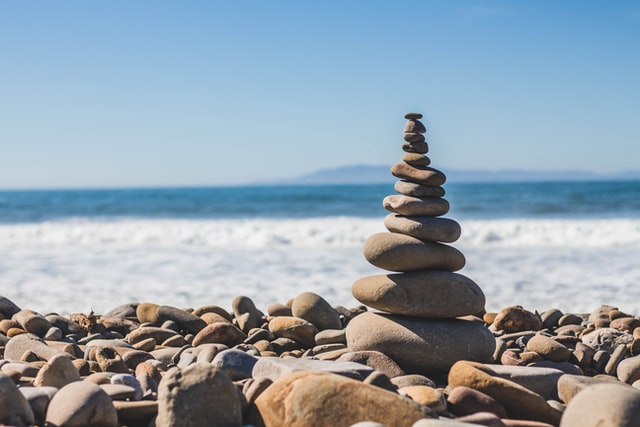

##### What I dream of is the art of balance (Henri Matisse)

It's not uncommon for data scientists to work on imabalnced data, i.e. such data where classes are not uniformly distributed and one or two classes present a vast majority. Actually, most of classification data is usually imbalanced. To name but a few: medical data to diagnose a condition, fraud detection data, churn client data etc. 

The problem here is that machine learning algorithms may overfit on the majority class and totally ignore the minor classes. At the same time, it is the minority class samples (a rare disease or a fraudulent transaction) that we are interested in detecting! One of the ways to overcome the problem of imbalanced data is resampling, i.e. changing the number of samples in the different classes. There are at least three ways to resample data:

- Oversampling: adding the minory class samples.
- Undersampling: deleting the majority class samples.
- Combination of oversampling and udnersampling.

In this notebook we will examine some popular resampling techniques as well as discover why **Accuracy** is not always a good evaluation metric.

First, we will look at different resampling methods in action and plot the results. Afterwards we are going to create a classification model on imbalanced data with and without resampling. 

### Load libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, classification_report
from sklearn.datasets import make_classification

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN


# <font color='navy'> Resampling on synthetic data
    
Let's create some imbalanced data to demonstrate the differene between resampling methods. 

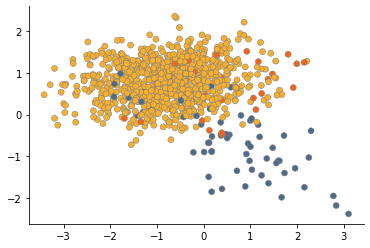

In [3]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.06, 0.02, 0.92],
                           class_sep=0.8, random_state=0)

colors = ['#4E6B8A' if v == 0 else '#F26419' if v == 1 else '#F6AE2D' for v in y]
fig = plt.Figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='grey', linewidths=0.5)
sns.despine()

First, let's try the most naive approach - random oversampling. This will create a duplicate samples of a minor class.

Text(0.5, 1.0, 'Random Oversampling')

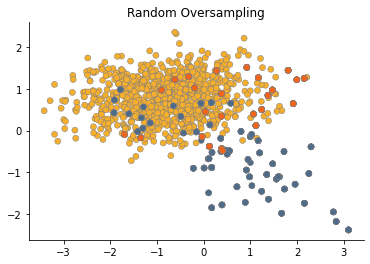

In [4]:
ros = RandomOverSampler(random_state=0, sampling_strategy={0: 300, 1: 300})
ros.fit(X, y)
X_resampled, y_resampled = ros.fit_resample(X, y)
colors = ['#4E6B8A' if v == 0 else '#F26419' if v == 1 else '#F6AE2D' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='grey')
sns.despine()
plt.title("Random Oversampling")

A more advanced method - SMOTE (Synthetic Minority Oversampling Technique) - doesn't just duplicate an existing sample. SMOTE generates a new sample considering its k neareast-neighbors.

Text(0.5, 1.0, 'SMOTE')

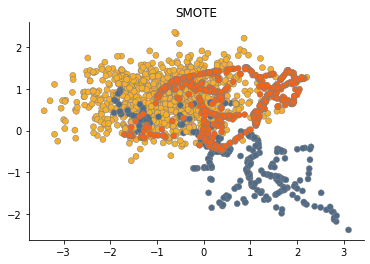

In [5]:
smote = SMOTE(random_state=0,  sampling_strategy={0: 300, 1: 500})
smote.fit(X, y)
X_resampled, y_resampled = smote.fit_resample(X, y)
colors = ['#4E6B8A' if v == 0 else '#F26419' if v == 1 else '#F6AE2D' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='grey')
sns.despine()
plt.title("SMOTE")

The plot shows that SMOTE generates many "noisy" samples that are placed between the outliers and the true minor samples.

To solve this problem, one may use any of "cleaning" undersampling methods. For instance, SMOTEEN (SMOTE + Edited Nearest Neighbours) generates new samples as a vanila SMOTE, but then deletes those which class is different from the k-nearest neighbours' class.

Text(0.5, 1.0, 'SMOTEEEN')

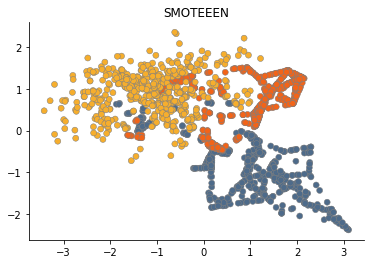

In [6]:
smote = SMOTEENN(random_state=0)
smote.fit(X, y)
X_resampled, y_resampled = smote.fit_resample(X, y)
colors = ['#4E6B8A' if v == 0 else '#F26419' if v == 1 else '#F6AE2D' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='grey')
sns.despine()
plt.title("SMOTEEEN")

The plot below shows how random undersampling, i.e. random deletion of major class samples, work.

Text(0.5, 1.0, 'Random Undersampling')

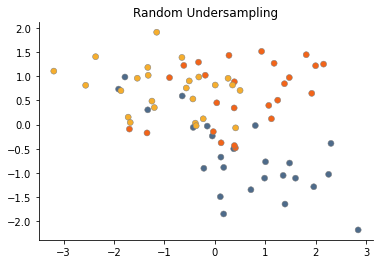

In [7]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)
colors = ['#4E6B8A' if v == 0 else '#F26419' if v == 1 else '#F6AE2D' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='grey')
sns.despine()
plt.title("Random Undersampling")

Another undersampling method - Near Miss - deletes the major class samples for which the average distance to the N closest samples of the minor class is the smallest.

Text(0.5, 1.0, 'Near Miiss')

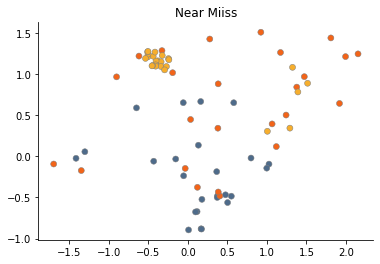

In [8]:
rus = NearMiss()
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)
colors = ['#4E6B8A' if v == 0 else '#F26419' if v == 1 else '#F6AE2D' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='grey')
sns.despine()
plt.title("Near Miiss")

# <font color='purple'> Resampling on real data

Now that we have a basic idea how different resampling approaches work, let's try to apply this knowledge in a real classification task. We are provided with the information about the results of a bank marketing campaign. Our __task__ is to predict whether the client signs a term deposit.

In [9]:
# data source: https://www.kaggle.com/sonujha090/bank-marketing
bank = pd.read_csv('bank.csv')

In [10]:
bank.shape

(4521, 17)

Now let's look at the distribution of the target variable.

<AxesSubplot:xlabel='y', ylabel='count'>

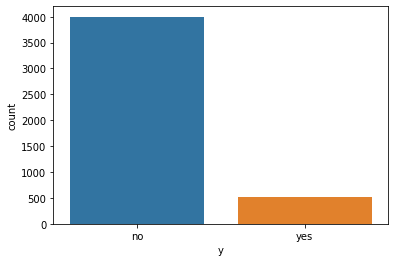

In [11]:
sns.countplot(x="y", data=bank)

In [12]:
bank.y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

It's clear that the data is imbalanced. There is much more information on people who declined to sign a deposit.

Let's take a look on a few samples in our dataset.

In [13]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


As we can see, there are some categorical features that need to be encoded.

In [14]:
bank["default"] = bank["default"].map({"no":0,"yes":1})

bank["housing"] = bank["housing"].map({"no":0,"yes":1})

bank["loan"] = bank["loan"].map({"no":0,"yes":1})

bank["y"] = bank["y"].map({"no":0,"yes":1})

bank.education = bank.education.map({"primary": 0, "secondary":1, "tertiary":2})

bank.month = pd.to_datetime(bank.month, format = "%b").dt.month

In [15]:
# Let's remove a few features that are not really relevant for the purposes of our task
bank.drop(["poutcome", "contact"], axis = 1, inplace = True)
bank.dropna(inplace = True)

Some other categorical variables will be encode with the help of ohe-hot encoding, i.e. each category of a feature will be now represented as a separate column.

In [16]:
bank = pd.get_dummies(bank, drop_first = True)

In [17]:
# The final features
bank.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'month', 'duration', 'campaign', 'pdays', 'previous', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single'],
      dtype='object')

In [18]:
# Separate the target variable from the rest of the feautures

X = bank.drop("y", axis = 1)
y = bank.y

__NB__: Don't forget to use stratification when splitting the data into train and test. This will help to preserve the same class distribution as in the whole dataset.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state = 1, stratify=y)

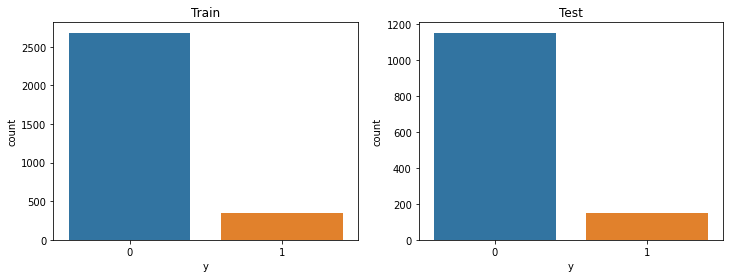

In [20]:
# Sanity check for class distribution in train and test.
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x='y', data=pd.DataFrame(y_train), ax=axs[0])
sns.countplot(x='y', data=pd.DataFrame(y_test), ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')

In [21]:
y_test.value_counts()

0    1150
1     151
Name: y, dtype: int64

## Baseline: logistic regression on imbalanced dataset  

In [22]:
# a helper function to draw confusion matrices
def draw_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm_norm)
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()
    print("Accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))
    print("Recall: {0:.3f}".format(recall_score(y_test, y_pred)))

In [23]:
lr = LogisticRegression(solver='liblinear',random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [24]:
y_pred = lr.predict(X_test)
print("Accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.892


Wow great! 89% of accurate predictions with a simple model. But should we really trust this metric? Let's take a closer look at the performance of the classifier. A confusion matrix and a classification report will be quite handy in this case.

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1150
           1       0.60      0.19      0.29       151

    accuracy                           0.89      1301
   macro avg       0.75      0.59      0.62      1301
weighted avg       0.87      0.89      0.87      1301



[[1131   19]
 [ 122   29]]


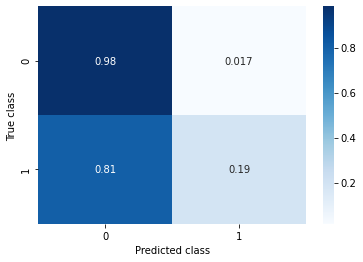

Accuracy: 0.892
Recall: 0.192


In [26]:
print(confusion_matrix(y_test, y_pred))
draw_cm(y_test, y_pred)

Here it is! Recall for class 1 - the class we are actually interested in - is lower 20%. What does that mean?

Well, let's imagine that this classifier is used in production, i.e. the marketing dept is relying on the model to identify people that would likely sign a term deposit. Do you see it now? We have effectively missed 80% of the potential clients!

In order to minimize the number of such misses, we need to pay closer attention to recall rather than relying solely on accuracy.

# <font color='scarlett'> The right way to use resampling: </font>

1. Split your data in train and test sets.
2. Resample __only__ the train set!
3. Estimate the classification quality on the test set.

Violating this procedure may lead to an inadequate evaluation results.

For example, if you first resample and split your data, the same sample may be found in both train and test sets. This would be a leakage of data - the model is tested on an object that was present in the train.

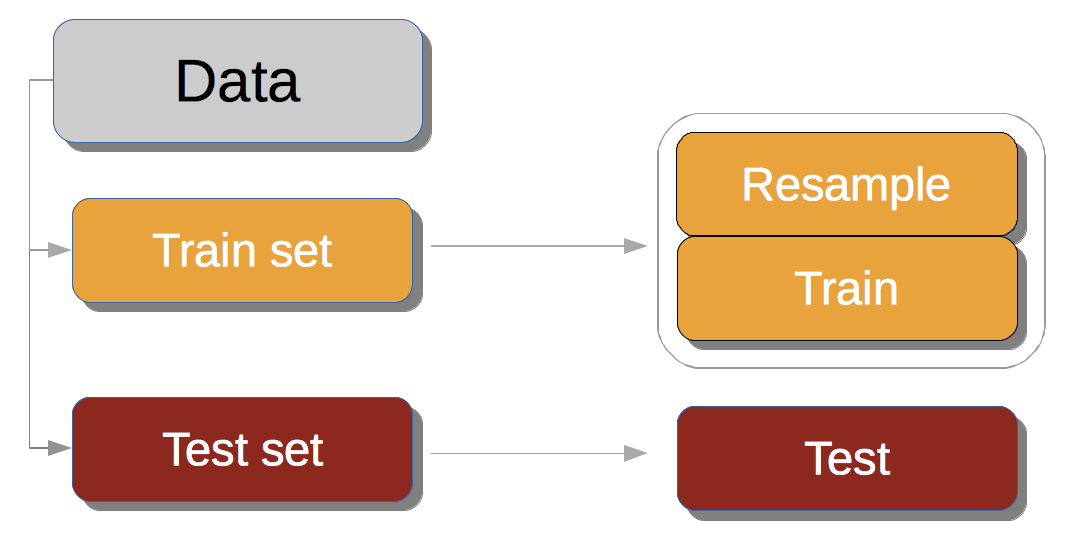

## <font color='green'> Oversampling
    
### <font color='green'> Random Oversampling

This approach simply duplicates existing samples of a minor class.

In [27]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=1)

X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
np.bincount(y_train_ros)

array([2682, 2682])

In [28]:
lr = LogisticRegression(solver='liblinear',random_state=1)
lr.fit(X_train_ros, y_train_ros)

y_pred = lr.predict(X_test)

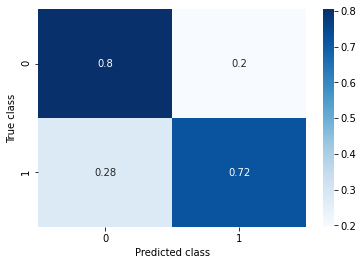

Accuracy: 0.795
Recall: 0.722


In [29]:
draw_cm(y_test, y_pred)

### <font color='green'> SMOTE

SMOTE generates new minor class samples by means of interpolation.

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
smt = SMOTE(random_state=1)

X_train_sm, y_train_sm = smt.fit_sample(X_train, y_train)
np.bincount(y_train_sm)

array([2682, 2682])

In [32]:
lr = LogisticRegression(solver='liblinear',random_state=1)
lr.fit(X_train_sm, y_train_sm)

y_pred = lr.predict(X_test)

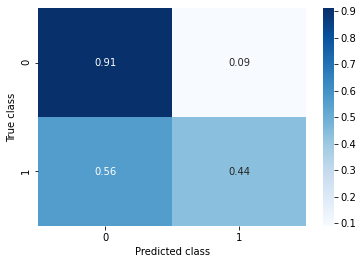

Accuracy: 0.855
Recall: 0.437


In [33]:
draw_cm(y_test, y_pred)

## <font color='scarlett'>  Undersampling
    
### <font color='scarlett'> Random Undersampling

Randomly delete some objects of major class.

In [34]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=1)

X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)
np.bincount(y_train_rus)

array([351, 351])

In [35]:
lr = LogisticRegression(solver='liblinear',random_state=1)
lr.fit(X_train_rus, y_train_rus)

y_pred = lr.predict(X_test)

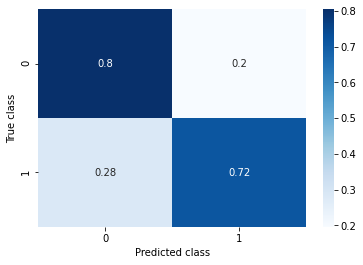

Accuracy: 0.794
Recall: 0.715


In [36]:
draw_cm(y_test, y_pred)

## <font color='navy'> Combination of oversampling и undersampling
    
SMOTE with Tomek's links:
1. Generate new samples with SMOTE
2. Delete objects that create Tomek's link. A Tomek’s link exist if the two samples are the nearest neighbors of each other. 

In [37]:
st = SMOTETomek(random_state=1)
X_train_st, y_train_st = st.fit_sample(X_train, y_train)
np.bincount(y_train_st)

array([2598, 2598])

In [38]:
lr = LogisticRegression(solver='liblinear',random_state=1)
lr.fit(X_train_st, y_train_st)

y_pred = lr.predict(X_test)

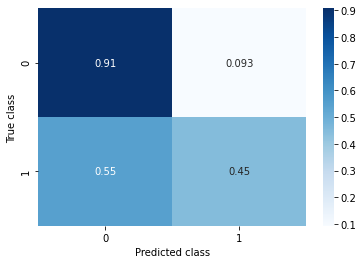

Accuracy: 0.854
Recall: 0.450


In [39]:
draw_cm(y_test, y_pred)

# Wrapping up

In this notebook, we have presented a few approaches to handle imbalanced data. We've seen how misleading can be such a metric as Accuracy in case of class imbalance. We've also given a closer look to differences between some resampling techniques. Finally, we've practiced to apply these methods on a real data. Hopefully, you've found this kernel usefull and easy to follow.